In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\PCD\.cache\kagglehub\datasets\crowww\a-large-scale-fish-dataset\versions\2


In [ ]:
# Main dataset directory
base_dir = os.path.join(path, "Fish_Dataset", "Fish_Dataset")

X = []  # images
y = []  # labels

# Loop through each fish species
for species in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species)
    if not os.path.isdir(species_path):
        continue

    # Loop inside each fish species folder
    for subfolder in os.listdir(species_path):
        subfolder_path = os.path.join(species_path, subfolder)

        # Skip mask folders (GT = Ground Truth)
        if "GT" in subfolder or not os.path.isdir(subfolder_path):
            continue

        # Read image files
        for img_file in os.listdir(subfolder_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(subfolder_path, img_file)

                # Read and preprocess
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))  # resize to standard shape

                X.append(img)
                y.append(species)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


print("Total images:", len(X))
print("Classes:", np.unique(y))
print("Image shape:", X[0].shape)


Total images: 9000
Classes: ['Black Sea Sprat' 'Gilt-Head Bream' 'Hourse Mackerel' 'Red Mullet'
 'Red Sea Bream' 'Sea Bass' 'Shrimp' 'Striped Red Mullet' 'Trout']
Image shape: (128, 128, 3)


In [ ]:
def bar_chart_cv(values, metric_name, model_name):

    folds = np.arange(1, len(values) + 1)
    mean_val = np.mean(values)

    plt.figure(figsize=(8, 5))

    bars = plt.bar(folds, values, color='skyblue')

    # Add value labels above bars
    for i, v in enumerate(values):
        plt.text(i + 1, v + 0.01, f"{v:.4f}", ha='center')

    # Mean line
    plt.axhline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f"Mean {metric_name} ({mean_val:.4f})")

    # Y-axis settings
    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.01, 0.20))


    plt.title(f"{metric_name} per Fold - {model_name}")
    plt.xlabel("Fold Number")
    plt.ylabel(metric_name)

    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [ ]:
def print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name):

    print(f"\n===== Cross-Validation Summary (Macro Averaged) — {model_name} =====")
    print(f"Mean Accuracy : {np.mean(acc_scores):.4f}")
    print(f"Mean Precision: {np.mean(prec_scores):.4f}")
    print(f"Mean Recall   : {np.mean(rec_scores):.4f}")
    print(f"Mean F1-score : {np.mean(f1_scores):.4f}")


## Split dataset

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Encode string labels to integers
le = LabelEncoder().fit(y_train)
n_classes = len(le.classes_)
y_train_cat = to_categorical(le.transform(y_train), num_classes=n_classes)
y_test_cat  = to_categorical(le.transform(y_test),  num_classes=n_classes)

# Normalize images for CNN
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32")  / 255.0

## CNN without Dropout

In [ ]:
def build_cnn_no_dropout(input_shape=(128, 128, 3), num_classes=9):

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

num_classes = y_train_cat.shape[1]
y_labels_train = np.argmax(y_train_cat, axis=1)  # for StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

best_accuracy = 0.0
best_model = None
best_history = None
best_y_pred = None
best_y_true = None
# -----------------------------------------------------------

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_labels_train), start=1):
    print(f"\n--- Fold {fold} ---")

    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_labels_train[train_idx], y_labels_train[val_idx]

    y_tr_cat = y_train_cat[train_idx]
    y_val_cat = y_train_cat[val_idx]

    model_cv = build_cnn_no_dropout(input_shape=X_train.shape[1:], num_classes=num_classes)

    history_dropout = model_cv.fit(
        X_tr, y_tr_cat,
        validation_data=(X_val, y_val_cat),
        epochs=10,
        batch_size=32,
        verbose=0
    )

    # Predictions
    y_val_pred_prob = model_cv.predict(X_val)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    # Metrics (macro)
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    #Check if this fold is the best so far
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model_cv
        best_history = history_dropout
        best_y_pred = y_val_pred
        best_y_true = y_val
    # --------------------------------------------------

print("\nFinal Average Results:")
print(f"Avg Accuracy : {np.mean(acc_scores):.4f}")
print(f"Best Accuracy Saved : {best_accuracy:.4f}")


--- Fold 1 ---


c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy : 0.9847
Precision: 0.9847
Recall   : 0.9846
F1-score : 0.9846

--- Fold 2 ---


c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Accuracy : 0.9722
Precision: 0.9731
Recall   : 0.9721
F1-score : 0.9720

--- Fold 3 ---


c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy : 0.9444
Precision: 0.9464
Recall   : 0.9442
F1-score : 0.9440

--- Fold 4 ---


c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy : 0.9778
Precision: 0.9778
Recall   : 0.9776
F1-score : 0.9775

--- Fold 5 ---


c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy : 0.9799
Precision: 0.9800
Recall   : 0.9798
F1-score : 0.9798

Final Average Results:
Avg Accuracy : 0.9718
Best Accuracy Saved : 0.9847


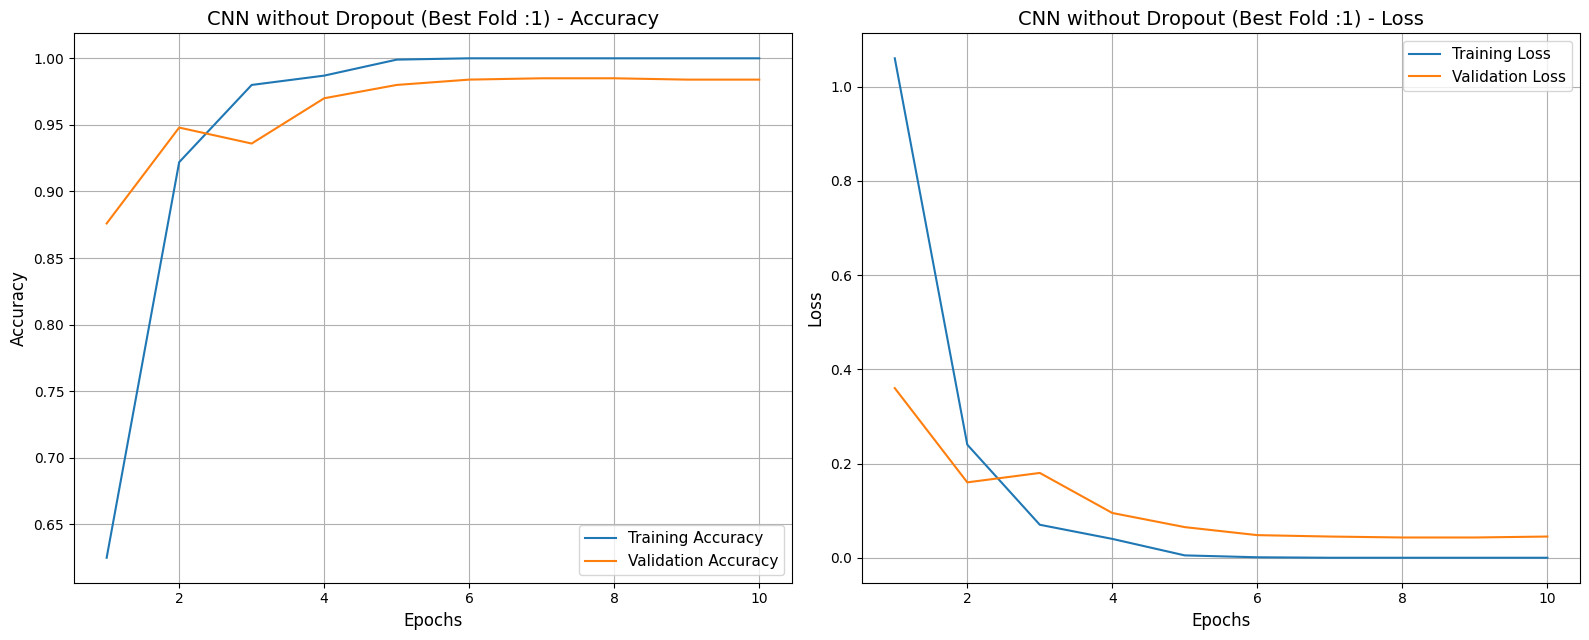

In [ ]:
def plot_best_history(history):
    # Extract data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 6.5))

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('CNN without Dropout (Best Fold :1) - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # --- Plot Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('CNN without Dropout (Best Fold :1) - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_best_history(best_history)

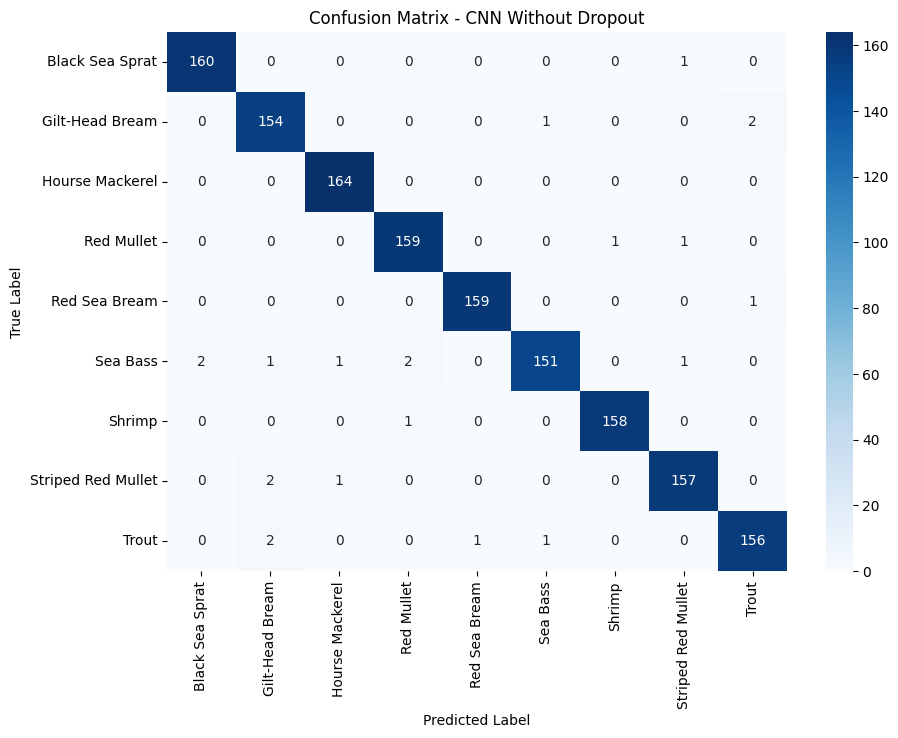

In [ ]:
# Confusion Matrix for BEST fold
cm = confusion_matrix(best_y_true, best_y_pred)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - CNN Without Dropout')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

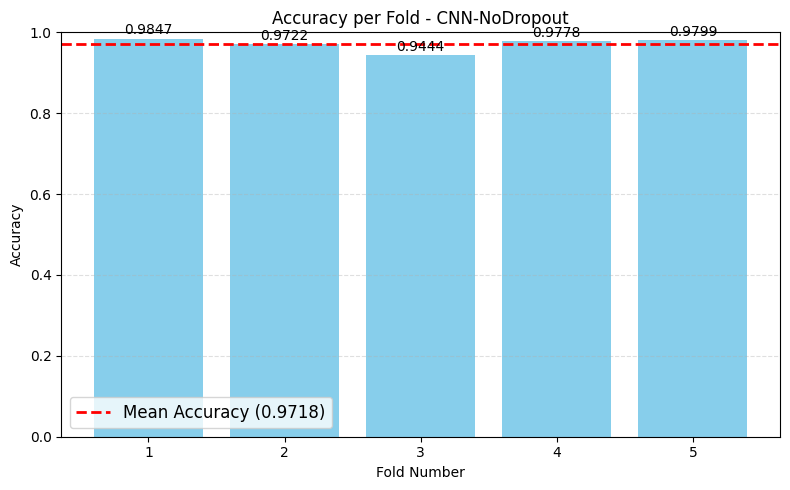

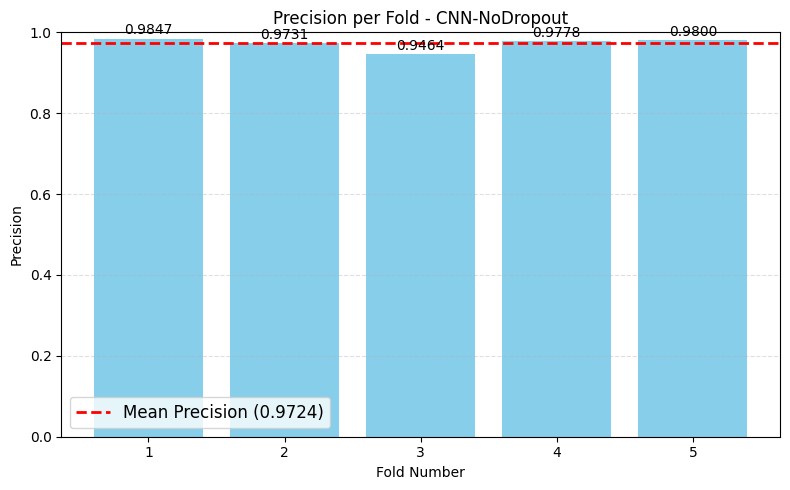

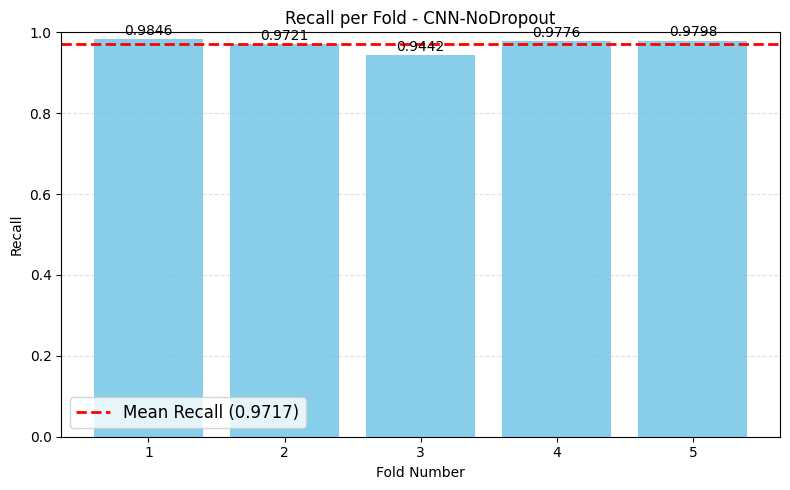

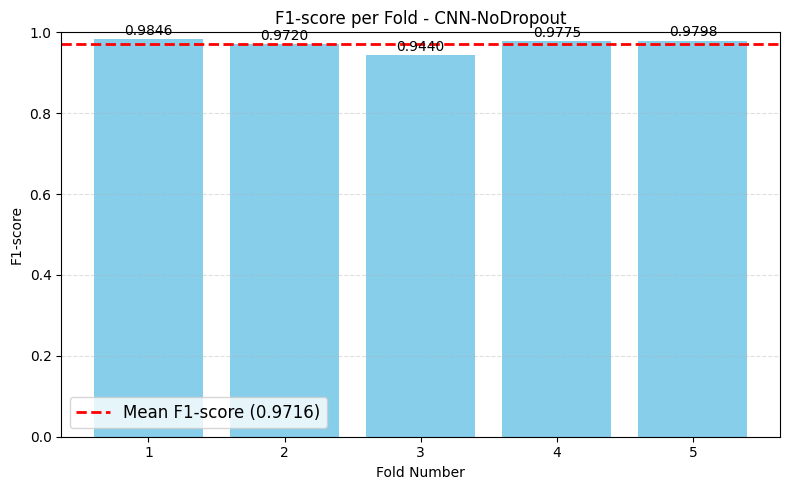


===== Cross-Validation Summary (Macro Averaged) — CNN-NoDropout =====
Mean Accuracy : 0.9718
Mean Precision: 0.9724
Mean Recall   : 0.9717
Mean F1-score : 0.9716


In [ ]:
bar_chart_cv(acc_scores, metric_name="Accuracy",  model_name="CNN-NoDropout")
bar_chart_cv(prec_scores, metric_name="Precision", model_name="CNN-NoDropout")
bar_chart_cv(rec_scores,  metric_name="Recall",    model_name="CNN-NoDropout")
bar_chart_cv(f1_scores,   metric_name="F1-score",  model_name="CNN-NoDropout")

print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name="CNN-NoDropout")
